# Auxiliary potential fields

Here, we'll demonstrate a solution of Laplace's equation,
with Neumann boundary conditions on a surface. Similar to the
Dirichlet problem in A Dirichlet Poisson problem, we will solve the
problem with one Neumann condition external to the surface,
and another Neumann value internal to the surface.

Our underlying problem is still

$$\nabla^2\varphi^+ = 0,\qquad \nabla^2\varphi^- = 0$$

where $+$ denotes the exterior and $-$ the interior of the surface. (We will
consider a circle of radius 1.) The boundary conditions on this surface are

$$\mathbf{n}\cdot\nabla\varphi^+ = v^+_n, \qquad \mathbf{n}\cdot\nabla\varphi^- = v^-_n$$

In other words, we seek to set the value on the exterior normal derivative to $v_n$
of the local normal vector on the surface, while the interior should have zero normal
derivative.

Discretizing this problem by the usual techniques, we seek to solve

$$\begin{bmatrix} L & D_s \\ G_s & R_n^T R_n \end{bmatrix} \begin{pmatrix} f \\ -[\phi] \end{pmatrix} = \begin{pmatrix} R [v_n] \\ \overline{v}_n \end{pmatrix}$$

where $\overline{v}_n = (v^+_n + v^-_n)/2$ and $[v_n] = v^+_n - v^-_n$. The resulting
$[\phi]$ is $f^+-f^-$.

As with the Dirichlet problem, this saddle-point problem can be solved by block-LU decomposition. First solve

$$L f^{*} = R [v_n]$$

for $f^*$. Then solve

$$-S [\phi] = \overline{v}_n - G_s f^{*}$$

for $[\phi]$, where $S = R_n^T R_n - G_s L^{-1} D_s = -C_s L^{-1}C_s^T$, and finally, compute

$$f = f^{*} + L^{-1}D_s [\phi]$$

It should be remembered that, for any scalar potential field, there is
a corresponding streamfunction $\psi$ that generates the same flow. We
can get that field, as well, with only a little bit more effort:

$$S [\psi] = C_s f^{*}$$

and then solve

$$L s = C_s^T [\phi] - \hat{C}_s^T [\psi]$$.

for the streamfunction $s$.

In [1]:
using MassivelySeparatedFlows
using Plots
using LinearAlgebra
#using UnPack

[ Info: Precompiling MassivelySeparatedFlows [4abfb38b-4535-4480-af0d-a3e8c83bd2d8]


## Set up the problem

###  Set up the grid
We make the grid a bit larger than we need, because the domain outer boundary for the auxiliary potential will be an
immersed surface placed just inside the grid boundary

In [2]:
Δx = 0.01
buffer_dist = 0.1

xlim_min, xlim_max = -1.5, 5.0
ylim_min, ylim_max = -2.5, 2.5

xlim = (xlim_min-buffer_dist, xlim_max+buffer_dist)
ylim = (ylim_min-buffer_dist, ylim_max+buffer_dist)
g = PhysicalGrid(xlim,ylim,Δx,nthreads_max=6)

PhysicalGrid{2}((677, 528), (163, 264), 0.01, ((-1.62, 5.13), (-2.63, 2.63)), 6)

### Set up the body

In [3]:
Δs = 1.4*cellsize(g);

bl = BodyList();
push!(bl,NACA4(0.0,0.0,0.12,Δs)) # The actual body is body 1

# The outer boundary is an immersed surface, body 2
halfx = 0.5*(xlim_max - xlim_min)
halfy = 0.5*(ylim_max - ylim_min)
xc, yc = 0.5*(xlim_max+xlim_min), 0.5*(ylim_max+ylim_min)
push!(bl,Rectangle(halfx,halfy,Δs)) 


# Place the bodies where you want them
t1 = MotionTransform([0.0,0.0],-π/4)  # Rotate and translate the body
t2 = MotionTransform([xc,yc],0.0) # Center the outer boundary
tl = MotionTransformList([t1,t2])
update_body!(bl,tl);

### Construct the system
We only need to do this once for a given geometry. It does not change for different choices of boundary condition. We will merely re-define the boundary condition function.

In [4]:
# We will redefine these below
function get_vnplus(base_cache,phys_params) end
function get_vnminus(base_cache,phys_params) end

bcdict = Dict("exterior"=>get_vnplus,"interior"=>get_vnminus)

Dict{String, Function} with 2 entries:
  "interior" => get_vnminus
  "exterior" => get_vnplus

In [5]:
prob = NeumannPoissonProblem(g,bl,bc=bcdict)
sys = construct_system(prob);

## Solve the problem

### Set the boundary condition functions
The interior boundary condition (inside the body) is always set to zero.

In [6]:
function get_vnminus(base_cache,phys_params)
    vnminus = zeros_surface(base_cache)
    return vnminus
end

get_vnminus (generic function with 1 method)

### Solve for the x potential
We define the outer boundary condition function to call the x potential boundary condition, `dfdn_nx`.

In [7]:
get_vnplus(base_cache,phys_params) = dfdn_nx(base_cache,phys_params)

fx, dfx, sx, dsx = solve(prob,sys);

### Plot the field

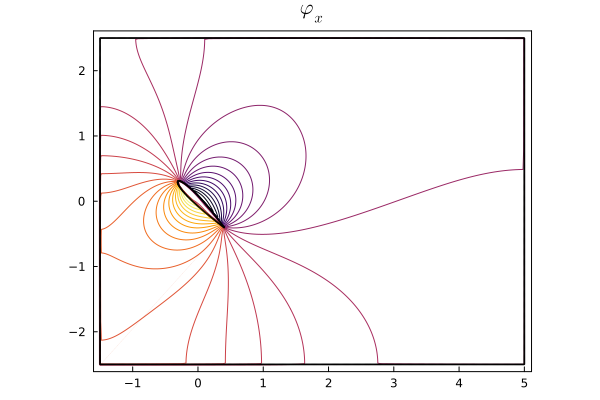

In [8]:
ps = plot(fx,sys,layers=true,levels=30,title="\$ϕ_x\$")
#savefig(ps,"phix.pdf")
ps

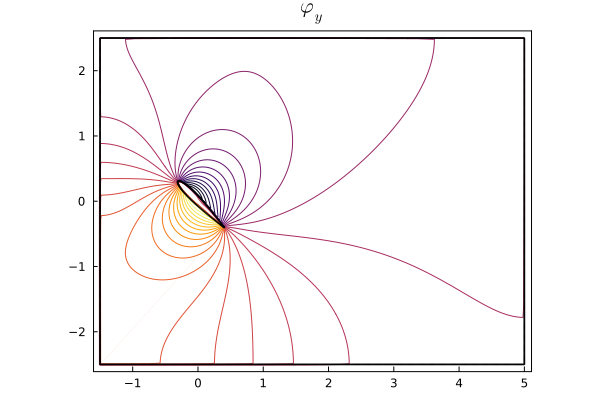

In [9]:
get_vnplus(base_cache,phys_params) = dfdn_ny(base_cache,phys_params)

fy, dfy, sy, dsy = solve(prob,sys);

ps = plot(fy,sys,layers=true,levels=30,title="\$ϕ_y\$")
ps

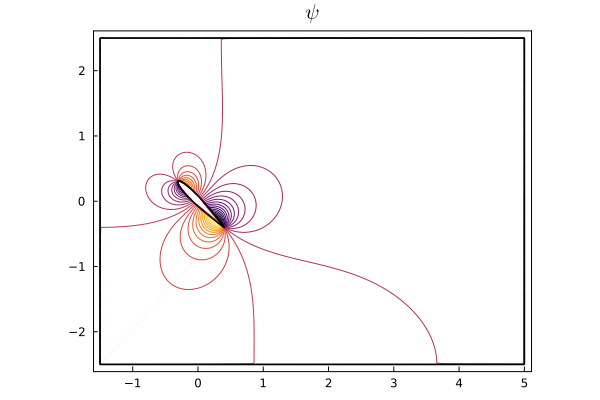

In [11]:
get_vnplus(base_cache,phys_params) = dfdn_xcrossn(base_cache,phys_params)

frot, dfrot, srot, dsrot = solve(prob,sys);

ps = plot(frot,sys,layers=true,levels=30,title="\$ψ\$")
ps

Now, let's compute the added mass components of the body associated
with this motion. We are approximating

$$M = -\int_{C_1} f^+ \mathbf{n}\mathrm{d}s$$

where $C_1$ is shape 1, and $f^+$ is simply $[\phi]$ on body 1.

In [15]:
nrm = normals(sys)
M = -integrate(dfx∘nrm,sys,1)

2-element Vector{Float64}:
 0.3173446307915659
 0.3043005433626655

As one would expect, the airfoil has added mass in the $x$ and $y$ directions
associated with moving in the $x$ direction.